

## Pitch Detection using Autocorrelation

There are several methods that can be used for pitch detection.
AMDF, ASMDF, YIN algorithm, MPM algorithm, Harmonic product spectrum, Cepstral analysis, and Autocorrelation are some popular approaches. More recently, machine learning has also been employed for this.

For our project we chose to use pYIN since it strikes a perfect balance between complexity and accuracy.

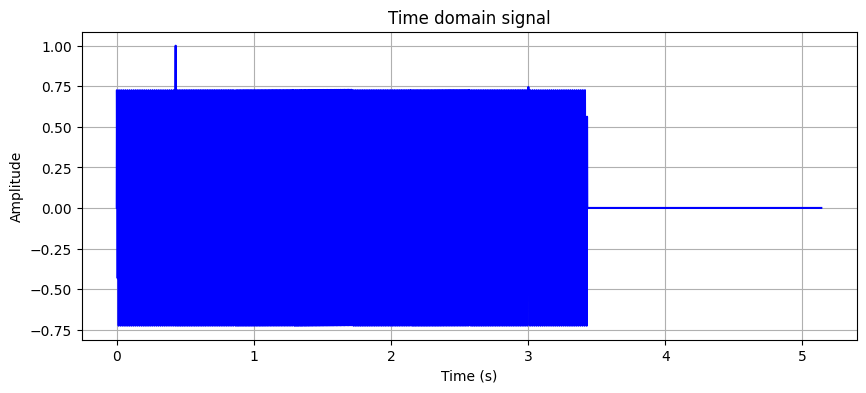

In [1]:
import numpy as np
import sys
import librosa
import matplotlib.pyplot as plt

track_path = "../../res/wav/1.wav"
track_data, sample_rate = librosa.load(track_path)

# Normalize the audio data
track_data = track_data.astype(np.float32) / np.max(np.abs(track_data))

# Create the time axis for the waveform plot
duration = len(track_data) / sample_rate
time_data = np.linspace(0.0, duration, len(track_data))


def crop_track(start, end, time_data, track_data, sample_rate):
    duration = len(time_data) / sample_rate
    if start < 0 or start > end or start > duration or end > duration:
        raise RuntimeError("Start/end should be in range")
    start_idx = int(start * sample_rate)
    end_idx = int(end * sample_rate)
    return (
        time_data[start_idx:end_idx],
        track_data[start_idx:end_idx],
    )


# Plot the time domain signal
plt.figure(figsize=(10, 4))
x_data, y_data = crop_track(0, duration, time_data, track_data, sample_rate)
plt.plot(x_data, y_data, color="b")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Time domain signal")
plt.grid(True)
plt.show()

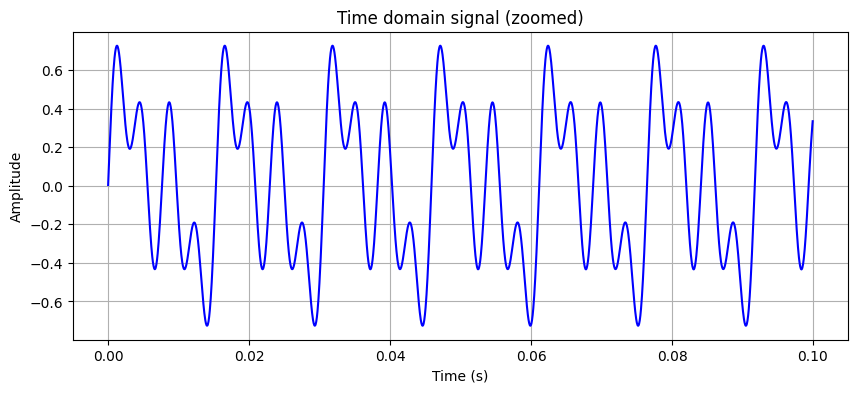

In [2]:
# Plot a small section of the time domain signal
plt.figure(figsize=(10, 4))
x_data, y_data = crop_track(0, 0.1, time_data, track_data, sample_rate)
plt.plot(x_data, y_data, color="b")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Time domain signal (zoomed)")
plt.grid(True)
plt.show()

In [3]:
f0, voiced_flag, voiced_probs = librosa.pyin(track_data,
                                             fmin=librosa.note_to_hz('C2'),
                                             fmax=librosa.note_to_hz('C7'),
                                             sr=sample_rate)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


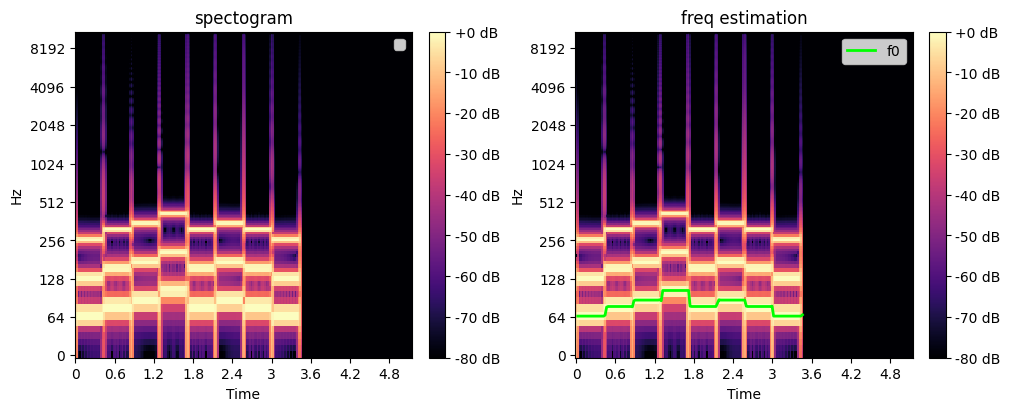

In [4]:
times = librosa.times_like(f0)
spectrogram_data = librosa.amplitude_to_db(np.abs(librosa.stft(track_data)), ref=np.max)

fig, (ax2, ax) = plt.subplots(1, 2, figsize=(10, 4), layout="constrained")

img = librosa.display.specshow(spectrogram_data, x_axis='time', y_axis='log', ax=ax)
img2 = librosa.display.specshow(spectrogram_data, x_axis='time', y_axis='log', ax=ax2)

ax.set(title='freq estimation')
ax2.set(title='spectogram')

fig.colorbar(img, ax=ax, format="%+2.f dB")
fig.colorbar(img2, ax=ax2, format="%+2.f dB")

ax.plot(times, f0, label='f0', color='lime', linewidth=2)

ax.legend(loc='upper right')
ax2.legend(loc='upper right')

In [5]:
import musicalbeeps

sys.path.append("..")
from melolib.music import Note
 
def coalesce_notes_and_rests(notes):
    coalesced_notes = []
    current_note = None
    current_duration = 0.0

    for note, duration in notes:
        if note == current_note or (note is None and current_note is None):  
            # If the current note is the same as the previous one, or both are rests
            current_duration += duration  # Accumulate the duration
        else:
            if current_note is not None:  # If there was a previous note, append it to coalesced_notes
                coalesced_notes.append((current_note, current_duration))
            current_note = note
            current_duration = duration

    # Append the last note or rest
    if current_note is not None or current_duration > 0:
        coalesced_notes.append((current_note, current_duration))

    return coalesced_notes

player = musicalbeeps.Player(volume = 1.0,
                            mute_output = False)
dt = times[1] - times[0]

notes = []
freqs = enumerate(f0)
for i, f in enumerate(f0):
    if f > 0:
        note = Note(int(librosa.hz_to_midi(f) - 12))
        notes.append((note, dt))
    else:
        notes.append((None, dt))
        
notes = coalesce_notes_and_rests(notes)
notes = [(note, dt) for note, dt in notes if dt > 0.05] # Remove all rests/notes that are not too long
notes = coalesce_notes_and_rests(notes)

for note, dt in notes:
    if note is not None:
        n, octave = note.get_name()
        accidental = "#" if "#" in n else ""
        note_repr = f"{n.replace('#', '')}{octave}{accidental}"
        player.play_note(note_repr, dt)
    else:
        player.play_note("pause", dt)

Playing C2 (65.41 Hz) for 0.4411791383219953s
Playing D2 (73.42 Hz) for 0.41795918367346924s
Playing E2 (82.41 Hz) for 0.3947392290249432s
Playing G2 (98.00 Hz) for 0.41795918367346924s
Playing D2 (73.42 Hz) for 0.3947392290249432s
Playing E2 (82.41 Hz) for 0.3947392290249432s
Playing D2 (73.42 Hz) for 0.37151927437641713s
Playing C2 (65.41 Hz) for 0.46439909297052134s
Pausing for 1.671836734693879s


In [72]:
def pyin_estimated_pitches_to_midi(notes, tempo, ticks_per_beat = 480):
    time = 0
    midi_notes = []
    for note, dt in notes:
        if note is not None:
            key, octave = note.get_name()
            start_tick = int(ticks_per_beat * (tempo / 60) * time)
            end_tick = int(ticks_per_beat * (tempo / 60) * (time + dt))
            midi_notes.append({
                "note": key,
                "octave": octave,
                "velocity": 1,
                "start_tick": start_tick,
                "end_tick": end_tick,
            })
        time += dt
    
    return {
        "ticks_per_beat": ticks_per_beat,
        "tracks": [ 
            midi_notes
        ]
    }

parsed_midi = pyin_estimated_pitches_to_midi(notes, 140)
print(parsed_midi)

{'ticks_per_beat': 480, 'tracks': [[{'note': 'C', 'octave': 4, 'velocity': 1, 'start_tick': 0, 'end_tick': 494}, {'note': 'D', 'octave': 4, 'velocity': 1, 'start_tick': 494, 'end_tick': 962}, {'note': 'E', 'octave': 4, 'velocity': 1, 'start_tick': 962, 'end_tick': 1404}, {'note': 'G', 'octave': 4, 'velocity': 1, 'start_tick': 1404, 'end_tick': 1872}, {'note': 'D', 'octave': 4, 'velocity': 1, 'start_tick': 1872, 'end_tick': 2314}, {'note': 'E', 'octave': 4, 'velocity': 1, 'start_tick': 2314, 'end_tick': 2756}, {'note': 'D', 'octave': 4, 'velocity': 1, 'start_tick': 2756, 'end_tick': 3172}, {'note': 'C', 'octave': 4, 'velocity': 1, 'start_tick': 3172, 'end_tick': 3692}]]}
